In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.training_transformer import TrainingTransformer
from src.learning.training.label_collector import LabelCollector
from src.learning.training.training_file_reader import TrainingFileReader
from src.learning.models import create_cnn, create_mlp, create_multi_model

config_manager = ConfigurationManager()
config = config_manager.config

reader = TrainingFileReader(path_to_training='../../training/laps/')
transformer = TrainingTransformer(config)
collector = LabelCollector()

# axis=2 for frames, axis=0 for telem and diffs
def memory_creator(instance, memory, length=4, interval=2, axis=2):
    memory.append(instance)
    
    near_memory = memory[::-interval]
    if len(near_memory) < length:
        return None
    
    if len(memory) >= length * interval:
        memory.pop(0)
        
    return np.concatenate(near_memory, axis=axis)


def read_stored_data(filename):
    df = reader.read_telemetry_as_csv(filename + '.csv')
    telemetry = collector.collect_numeric_inputs(df)
    diffs = collector.collect_expert_labels(df)

    frames = reader.read_training_video(filename + '.avi')
    resized_frames_np = transformer.resize_video_for_training(frames)

    return resized_frames_np, telemetry, diffs


def prep_full_mem_datas(frames, telemetry, diffs, length, interval):    
    mem_slice_frames = []
    mem_slice_telemetry = []
    mem_slice_diffs = []
    
    mem_frames = []
    for frame in frames:
        mem_frame = memory_creator(frame, mem_slice_frames, length=length, interval=interval, axis=2)

        if mem_frame is not None:
            mem_frames.append(mem_frame)
    mem_frames_np = np.array(mem_frames)
    
    mem_telemetry = []
    for index, telem in telemetry.iterrows():
        mem_telem = memory_creator(telem, mem_slice_telemetry, length=length, interval=interval, axis=0)

        if mem_telem is not None:
            mem_telemetry.append(mem_telem)
    mem_telemetry_np = np.array(mem_telemetry)
    
    mem_diffs = []
    for index, diff in telemetry.iterrows():
        mem_diff = memory_creator(diff, mem_slice_diffs, length=length, interval=interval, axis=0)

        if mem_diff is not None:
            mem_diffs.append(mem_diff)
    mem_diffs_np = np.array(mem_diffs)

    return mem_frames_np, mem_telemetry_np, mem_diffs_np


def prep_mem_datas(frames, telemetry, diffs, length, interval):
    mem_telemetry = telemetry
    mem_diffs = diffs
    
    memory = []
    mem_frames = []
    for frame in frames:
        mem_frame = memory_creator(frame, memory, length=length, interval=interval, axis=2)

        if mem_frame is not None:
            mem_frames.append(mem_frame)

    mem_frames_np = np.array(mem_frames)

    len_diff = mem_telemetry.shape[0] - mem_frames_np.shape[0]
    if len_diff > 0:
        mem_telemetry = mem_telemetry.iloc[len_diff:]
        mem_diffs = mem_diffs.iloc[len_diff:]
    
    mem_telemetry_np = mem_telemetry.to_numpy()
    mem_diffs_np = mem_diffs.to_numpy()

    return mem_frames_np, mem_telemetry_np, mem_diffs_np


def plot_stuff(title, plot_elems, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Epoch')
    x = np.arange(0, len(plot_elems[0]['data']), 1)
    
    for plot_elem in plot_elems:
        plt.errorbar(x, plot_elem['data'], yerr=plot_elem['error'], label=plot_elem['label'], alpha=plot_elem['alpha'], fmt='-o', capsize=5)

    plt.grid(axis='x')
    plt.legend(loc='best', prop={'size': 15})
    plt.show()
    plt.savefig('./' + title + '.png')

    
filenames = ['lap_5_2020_01_24', 'lap_6_2020_01_24', 'lap_7_2020_01_24']

In [18]:
frames, telems, diffs = read_stored_data(filenames[0])
mem_frames, mem_telems, mem_diffs = prep_full_mem_datas(*read_stored_data(filenames[0]), 4, 1)

print(mem_frames.shape)
print(mem_telems.shape)
print(mem_diffs.shape)

(4165, 40, 60, 12)
(4165, 16)
(4165, 16)


In [2]:
experiments = [(1, 1), (4, 1), (8, 1), (16, 1)]
datas_list = []

for experiment in tqdm(experiments):
    frames_mem = None
    telemetry_mem = None
    diffs_mem = None
    
    for training_file in filenames:
        frames_i, telem_i, diffs_i = prep_mem_datas(*read_stored_data(training_file), *experiment)
        
        if frames_mem is None and telemetry_mem is None and diffs_mem is None:
            frames_mem = frames_i
            telemetry_mem = telem_i
            diffs_mem = diffs_i
        else:
            frames_mem = np.append(frames_mem, frames_i, axis=0)
            telemetry_mem = np.append(telemetry_mem, telem_i, axis=0)
            diffs_mem = np.append(diffs_mem, diffs_i, axis=0)
        
    datas_list.append((frames_mem, telemetry_mem, diffs_mem))

In [3]:
import gc

epochs = 15
batch_size = 32
verbose = 0

results = {}

for data in tqdm(datas_list):
    result_desc = "N={}, M={}".format(*experiments[datas_list.index(data)])
    tqdm.write(result_desc)
    
    losses = []
    val_losses = []
    for i in tqdm(range(0, 20)):
        frames_train, frames_test, telemetry_train, telemetry_test, diffs_train, diffs_test = train_test_split(*data, test_size=0.2)
        
        mlp = create_mlp()
        cnn = create_cnn(input_shape=frames_train[0].shape)
        multi = create_multi_model(mlp, cnn)
    
        hist = multi.fit([telemetry_train, frames_train], diffs_train,
                        validation_data=([telemetry_test, frames_test], diffs_test),
                        epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        losses.append(hist.history['loss'])
        val_losses.append(hist.history['val_loss'])
        gc.collect()
    
    mean_losses = [np.mean(i) for i in zip(*losses)]
    std_losses = [np.std(i) for i in zip(*losses)]
    mean_val_losses = [np.mean(i) for i in zip(*val_losses)]
    std_val_losses = [np.std(i) for i in zip(*val_losses)]
    
    results[result_desc] = mean_losses
    results[result_desc + ' std'] = std_losses
    results[result_desc + ' raw'] = losses
    results[result_desc + ' val'] = mean_val_losses
    results[result_desc + ' val std'] = std_val_losses
    results[result_desc + ' val raw'] = val_losses
    
    tqdm.write("Mean loss per epoch: {}".format(mean_losses))
    tqdm.write("Mean validation loss per epoch: {}".format(mean_val_losses))

print(results)

N=1, M=1



Mean loss per epoch: [0.3341431928825614, 0.19862513140751556, 0.14233394083855616, 0.11141532860491646, 0.08867885997570066, 0.07060727105918921, 0.05540076963771999, 0.0413684821673407, 0.03487046324852498]
Mean validation loss per epoch: [0.2202248613564643, 0.15234936638768717, 0.11503335125497918, 0.09587746675835795, 0.07536725380343029, 0.05990401313278308, 0.04476033996142177, 0.03417212381227859, 0.030507085688364917]
N=4, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.



Mean loss per epoch: [0.3220496347352419, 0.18024924363043335, 0.1208833633887398, 0.09421849938105362, 0.07790732942325915, 0.06564451235565807, 0.0553804487010278, 0.04628131498942954, 0.040091906380104916]
Mean validation loss per epoch: [0.2094247746782766, 0.12160994723449936, 0.09567601242082582, 0.08065026869608774, 0.0678680913835871, 0.05764578479110336, 0.048247443004316985, 0.0406844939941929, 0.035986593192939065]
N=8, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.



Mean loss per epoch: [0.3329036653230665, 0.18557243090994918, 0.12098074215289616, 0.09124901789179586, 0.07465895625162636, 0.06319152909607356, 0.054142111694894614, 0.04707926243696643, 0.041677790657511274]
Mean validation loss per epoch: [0.21172071097822515, 0.12474195046745629, 0.09061502359996276, 0.07452313701115096, 0.06339410625713515, 0.05476296254844781, 0.04714141964196157, 0.04113409690059595, 0.03689251050005513]
N=16, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.



Mean loss per epoch: [0.35789706271601046, 0.20311665708033963, 0.13490545031207024, 0.10367694840866537, 0.08239854649711124, 0.06691681947549717, 0.05537598499813383, 0.04538551404799597, 0.03964272315474261]
Mean validation loss per epoch: [0.23233447604680557, 0.14178496140819105, 0.10817256308447534, 0.08899721343418304, 0.07173432191724285, 0.05959232739842096, 0.04903594338149262, 0.0410765036116134, 0.03664595154253712]

{'N=1, M=1': [0.3341431928825614, 0.19862513140751556, 0.14233394083855616, 0.11141532860491646, 0.08867885997570066, 0.07060727105918921, 0.05540076963771999, 0.0413684821673407, 0.03487046324852498], 'N=1, M=1 std': [0.045842586780062027, 0.03530430260147492, 0.039852008841387454, 0.03508411500838152, 0.02386425763087579, 0.014026632255437547, 0.004057245268587064, 0.01002256948951597, 0.010933845472039636], 'N=1, M=1 raw': [[0.4178585552507453, 0.2309132890166884, 0.1388429345697803, 0.08272896486744509, 0.06913727820541093, 0.061852243508595486, 0.05712765

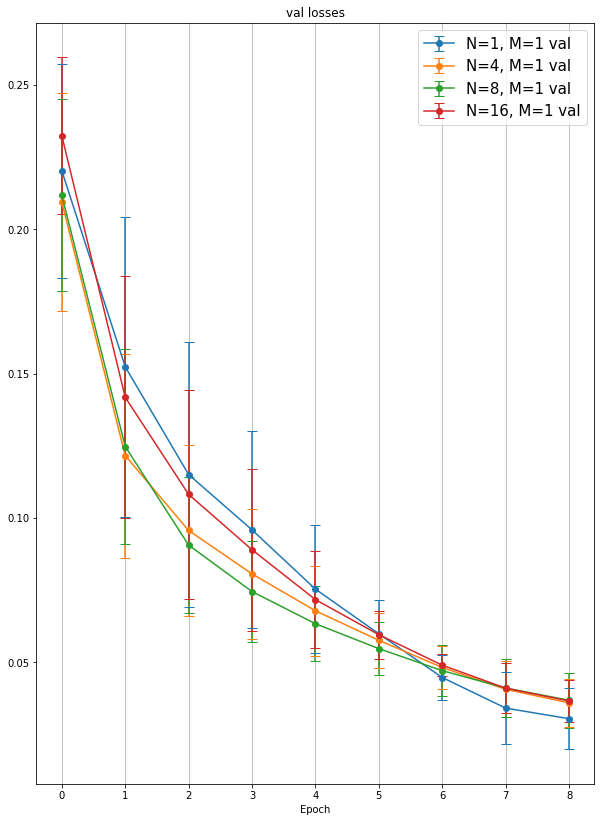

<Figure size 432x288 with 0 Axes>

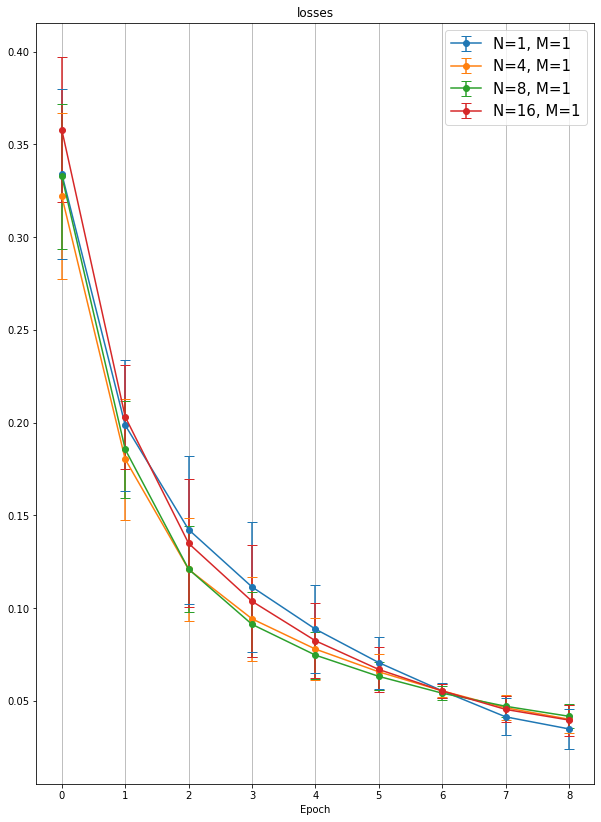

<Figure size 432x288 with 0 Axes>

In [8]:
loss_data = []
val_loss_data = []

for key, loss in results.items():
    if 'std' in key or 'raw' in key:
        continue
    
    if 'val' in key:
        val_loss_data.append({'data': loss, 'error': results[key + ' std'], 'label': key, 'alpha': 1.0})
    else:
        loss_data.append({'data': loss, 'error': results[key + ' std'], 'label': key, 'alpha': 1.0})
        
plot_stuff("val losses", val_loss_data, figsize=(10, 14))
plot_stuff("losses", loss_data, figsize=(10, 14))

In [ ]:
mlp = create_mlp()
cnn = create_cnn(input_shape=frames_train[0].shape)
multi = create_multi_model(mlp, cnn)
#multi.summary()

from keras.utils import plot_model
plot_model(multi, to_file='../../../Downloads/multi_model.png')